<a href="https://colab.research.google.com/github/danielselmin/scientific_literature/blob/main/miniproject2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
pip install scanpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.2/119.2 kB 13.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 11.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 10.5 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86831 sha256=429a5590f93a64ef046a6e246b59bc8bb0ab2818fcb870fc06f8d2d830d3a867
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8026 sha256=1d9fe3518a9566955d76a23c08ba2328525918064b9d72006ae1c2f919db03ad
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9

In [4]:
from google.colab import files
uploaded = files.upload()

Saving GSM3399102_rawCounts.csv.gz to GSM3399102_rawCounts.csv.gz


In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

# use anaconda/miniconda to ensure packages are right version, otherwise plotting might give error for color

## Load data

In [100]:
adata = sc.read_csv("GSM3399102_rawCounts.csv.gz").T

## 1. Quality control

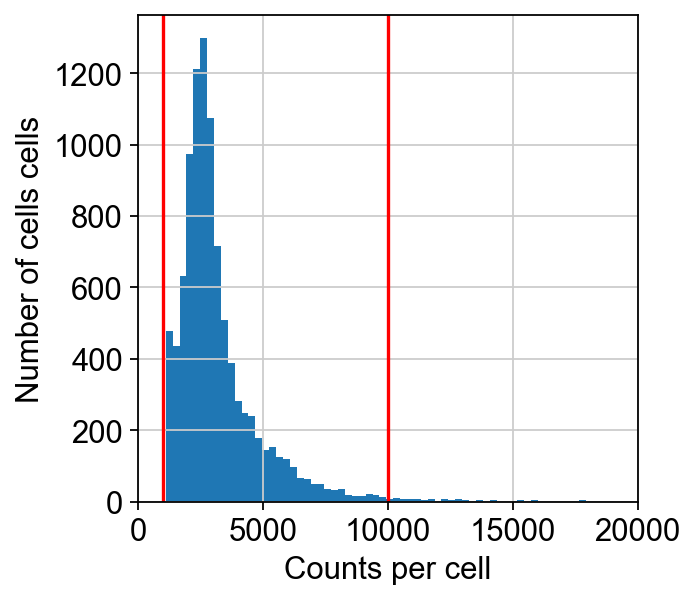

In [101]:
adata.obs['n_counts'] = adata.X.sum(axis=1)
plt.hist(adata.obs['n_counts'], bins=100)
plt.xlabel("Counts per cell") # what are you plotting on the x-axis? Label it!
plt.ylabel("Number of cells cells") # what are you plotting on the x-axis? Label it!
plt.axvline(1000, c="r") # specify the lower cutoff value for total UMIs
plt.axvline(10000, c="r") # specify the upper cutoff value for total UMIs
plt.xlim(0, 20000)
plt.show()

From the plot, the data is already filtered for UMI counts per cell

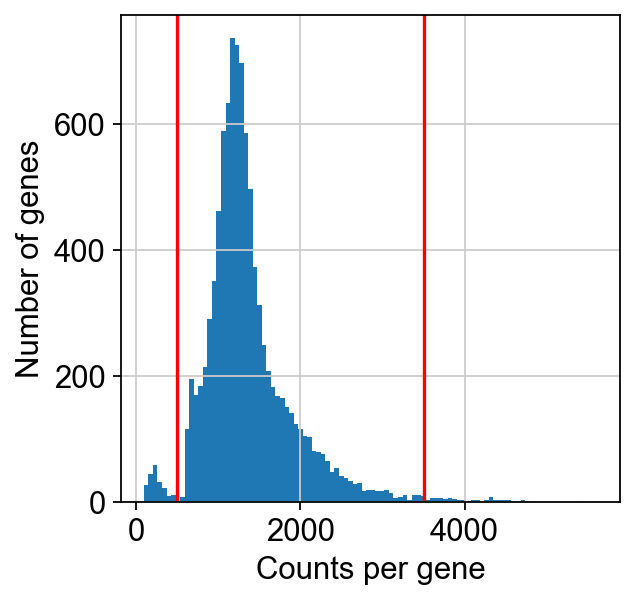

In [102]:
# look at gene counts per geneb
expressed_genes = np.sum(adata.X > 0, 1)
adata.obs['n_genes'] = expressed_genes

plt.hist(adata.obs['n_genes'], bins=100)
plt.axvline(500, c="r") # specify the lower cutoff for number of detected genes
plt.axvline(3500, c="r") # specify the upper cutoff for number of detected genes
plt.xlabel("Counts per gene") # what are you plotting on the x-axis? Label it!
plt.ylabel("Number of genes") # what are you plotting on the x-axis? Label it!
plt.show()

c:\Users\jurri\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jurri\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jurri\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jurri\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is

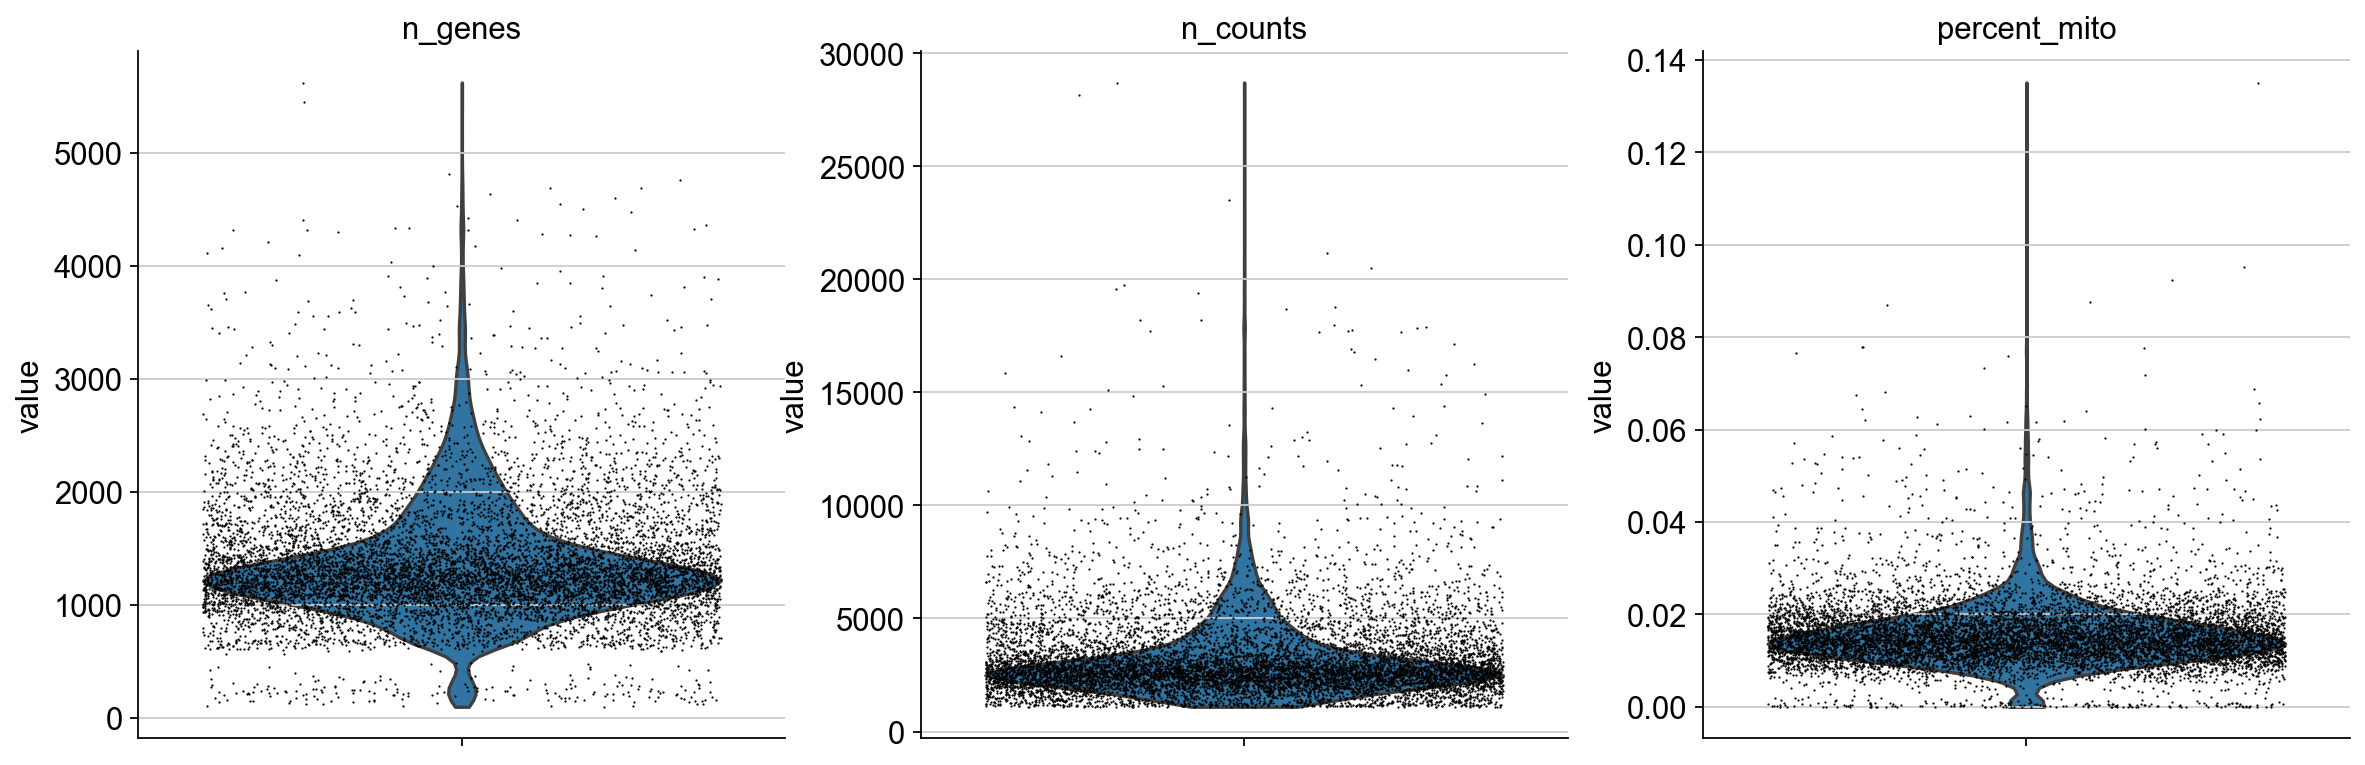

In [103]:
# finally check percentage of mitochondrial genes
mito_genes = adata.var_names.str.startswith('mt-')
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], jitter=0.4, multi_panel=True)

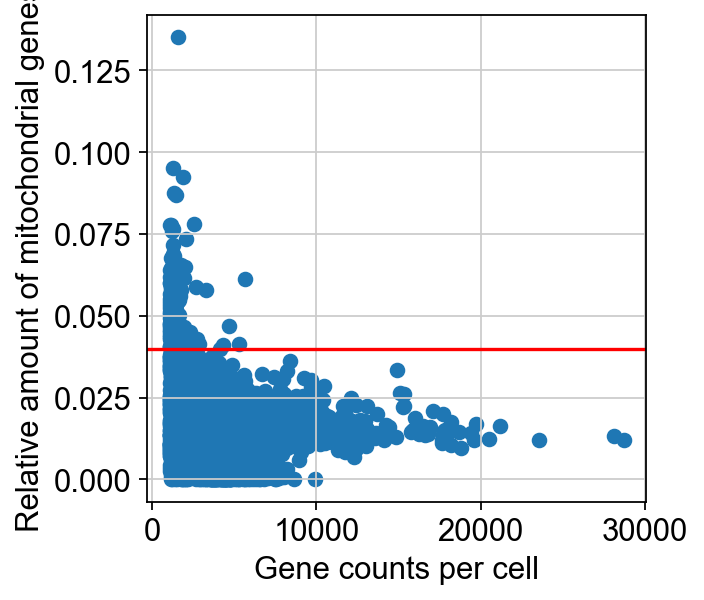

In [104]:
plt.scatter(adata.obs["n_counts"], adata.obs["percent_mito"])
plt.xlabel("Gene counts per cell") # specify the lower cutoff for number of detected genes
plt.ylabel("Relative amount of mitochondrial genes") # specify the lower cutoff for number of detected genes
plt.axhline(0.04, c='red') # specify a threshold (decimal from 0 to 1) for percentage mitochondrial reads
plt.show()

## 1.1 filter the data
Based on the above plots, we suggest to cut-off data for higher than 0.04 mitochondrial percentage,and to keep data within 500 and 3500 counts per gene and 1000to 10,000 gene counts per cell.
To improve, set boundaries with some algorithm based on the distributions?

In [105]:
sc.pp.filter_cells(adata, min_counts=1000) # apply threshold from above to actually do the filtering
sc.pp.filter_cells(adata, max_counts=10000) # apply threshold from above to actually do the filtering
sc.pp.filter_cells(adata, min_genes=500) # apply threshold from above to actually do the filtering
sc.pp.filter_cells(adata, max_genes=3500) # apply threshold from above to actually do the filtering
adata = adata[adata.obs['percent_mito'] < 0.05, :].copy() # apply threshold from above to actually do the filtering

filtered out 114 cells that have more than 10000 counts
filtered out 200 cells that have less than 500 genes expressed


In [106]:
# filter genes expressed in less than 1% of cells (why?)
sc.pp.filter_genes(adata, min_cells=adata.n_obs*0.01)

filtered out 17704 genes that are detected in less than 94.58 cells


## 2. Normalization
Address variability caused by sc sequencing process

In [107]:
adata.raw = adata.copy()
adata_raw = adata.copy()

In [108]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


## 3. Feature selection

In [109]:
# Get cell states (S, G2m vs G1, G0)
S_genes_mouse = ['Mcm5', 'Pcna', 'Tyms', 'Fen1', 'Mcm2', 'Mcm4', 'Rrm1', 'Ung',
       'Gins2', 'Mcm6', 'Cdca7', 'Dtl', 'Prim1', 'Uhrf1', 'Cenpu',
       'Hells', 'Rfc2', 'Rpa2', 'Nasp', 'Rad51ap1', 'Gmnn', 'Wdr76',
       'Slbp', 'Ccne2', 'Ubr7', 'Pold3', 'Msh2', 'Atad2', 'Rad51', 'Rrm2',
       'Cdc45', 'Cdc6', 'Exo1', 'Tipin', 'Dscc1', 'Blm', 'Casp8ap2',
       'Usp1', 'Clspn', 'Pola1', 'Chaf1b', 'Brip1', 'E2f8']
G2M_genes_mouse = ['Hmgb2', 'Cdk1', 'Nusap1', 'Ube2c', 'Birc5', 'Tpx2', 'Top2a',
       'Ndc80', 'Cks2', 'Nuf2', 'Cks1b', 'Mki67', 'Tmpo', 'Cenpf',
       'Tacc3', 'Pimreg', 'Smc4', 'Ccnb2', 'Ckap2l', 'Ckap2', 'Aurkb',
       'Bub1', 'Kif11', 'Anp32e', 'Tubb4b', 'Gtse1', 'Kif20b', 'Hjurp',
       'Cdca3', 'Jpt1', 'Cdc20', 'Ttk', 'Cdc25c', 'Kif2c', 'Rangap1',
       'Ncapd2', 'Dlgap5', 'Cdca2', 'Cdca8', 'Ect2', 'Kif23', 'Hmmr',
       'Aurka', 'Psrc1', 'Anln', 'Lbr', 'Ckap5', 'Cenpe', 'Ctcf', 'Nek2',
       'G2e3', 'Gas2l3', 'Cbx5', 'Cenpa']

sc.tl.score_genes_cell_cycle(adata, s_genes=S_genes_mouse, g2m_genes=G2M_genes_mouse)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    814 total control genes are used. (0:00:01)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    896 total control genes are used. (0:00:01)
-->     'phase', cell cycle phase (adata.obs)


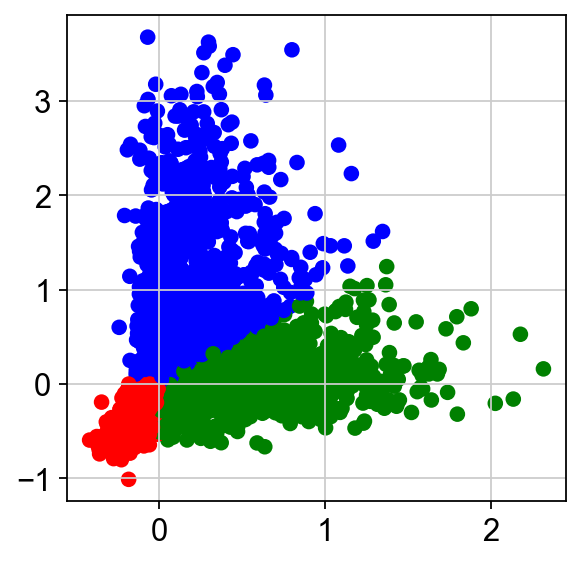

In [110]:
n2c = {"G1":"red", "S":"green", "G2M":"blue"} # use to assign each cell a color based on phase in the scatter plot
colors = []
for phase in adata.obs['phase']:
    colors.append(n2c[phase])

plt.scatter(adata.obs['S_score'], adata.obs['G2M_score'], c=colors)
plt.show()

In [111]:
adata.obs["phase"].value_counts()

phase
G1     6776
S      1683
G2M     999
Name: count, dtype: int64

Select 4000 highest variance components

In [112]:
sc.pp.highly_variable_genes(adata, n_top_genes=4000, min_disp=0.5, 
                            max_disp=np.inf, min_mean=0.0125, max_mean=3, span=0.3)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [113]:
adata = adata[:, adata.var["highly_variable"]].copy() # actually do the filtering

In [114]:
adata

AnnData object with n_obs × n_vars = 9458 × 4000
    obs: 'n_counts', 'n_genes', 'percent_mito', 'S_score', 'G2M_score', 'phase'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [164]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito', 'S_score', 'G2M_score']) # specify which feature from adata.obs you want to regress out, if any

regressing out ['n_counts', 'percent_mito', 'S_score', 'G2M_score']
    finished (0:00:45)


## 4. Principal component analysis

In [165]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:07)


c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


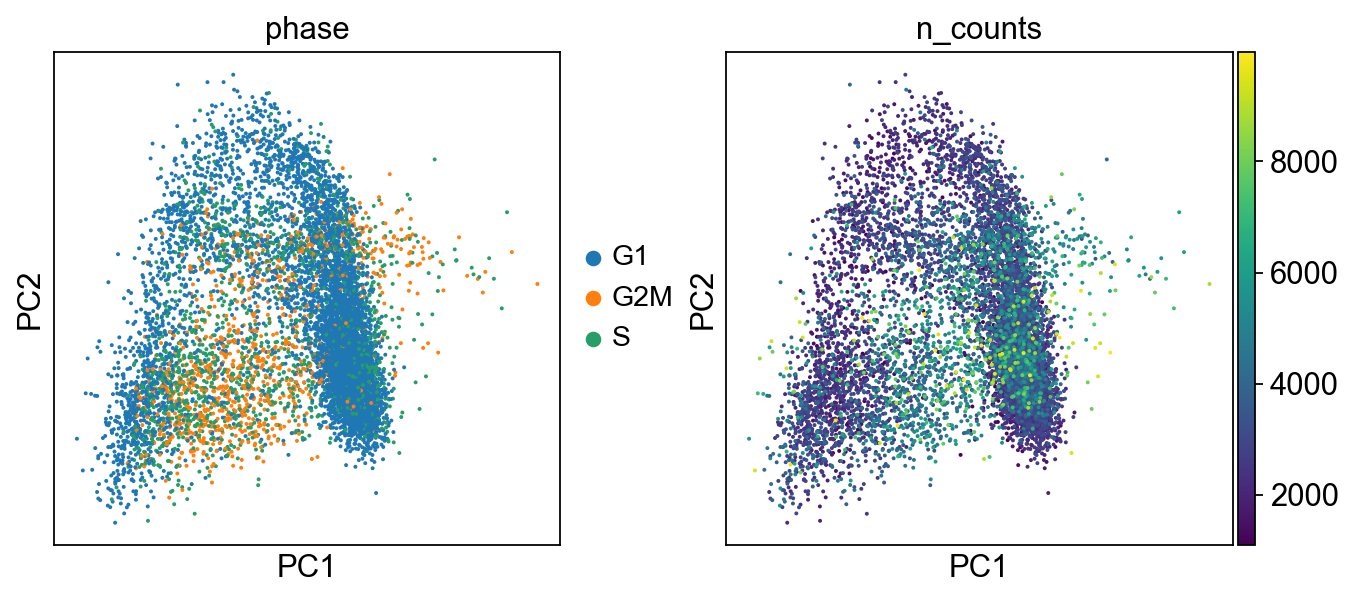

In [166]:
sc.pl.pca(adata, color=['phase','n_counts'])

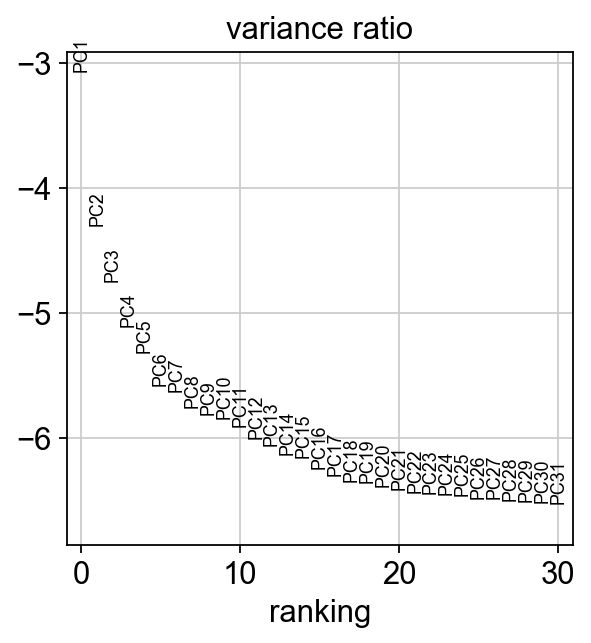

In [167]:
sc.pl.pca_variance_ratio(adata, log=True) # see contribution of each PC to variance

## 5. Dimensionality reduction 

In [168]:
sc.pp.neighbors(adata, n_neighbors=100, n_pcs=30) # specify the number of neighbors and number of PCs you wish to use

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)


In [169]:
sc.tl.tsne(adata, random_state=0)

computing tSNE
    using 'X_pca' with n_pcs = 50
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:01:14)


In [170]:
sc.tl.umap(adata, alpha=0.3, min_dist=0.5, random_state=0)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)


c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


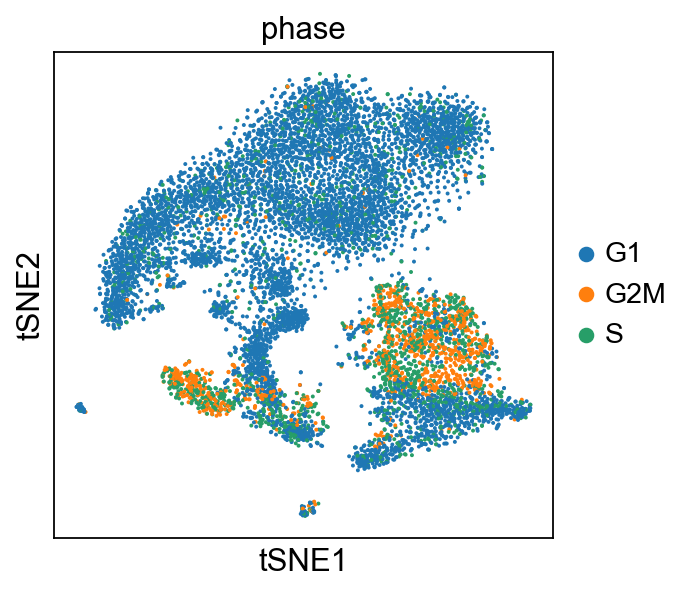

In [171]:
# visualize the tSNE colored by phase
sc.pl.tsne(adata, color='phase', use_raw=False, wspace=0.3, ncols=3)

c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


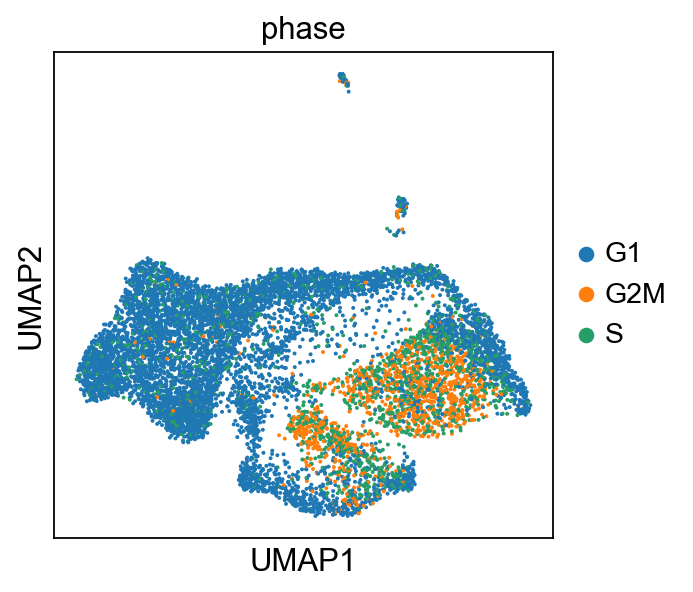

In [172]:
# visualize the UMAP colored by phase
sc.pl.umap(adata, color='phase', use_raw=False, wspace=0.3, ncols=3)

## 6. Clustering

In [173]:
resolution = 2
sc.tl.leiden(adata, resolution=resolution)

running Leiden clustering
    finished: found 19 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:12)


c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


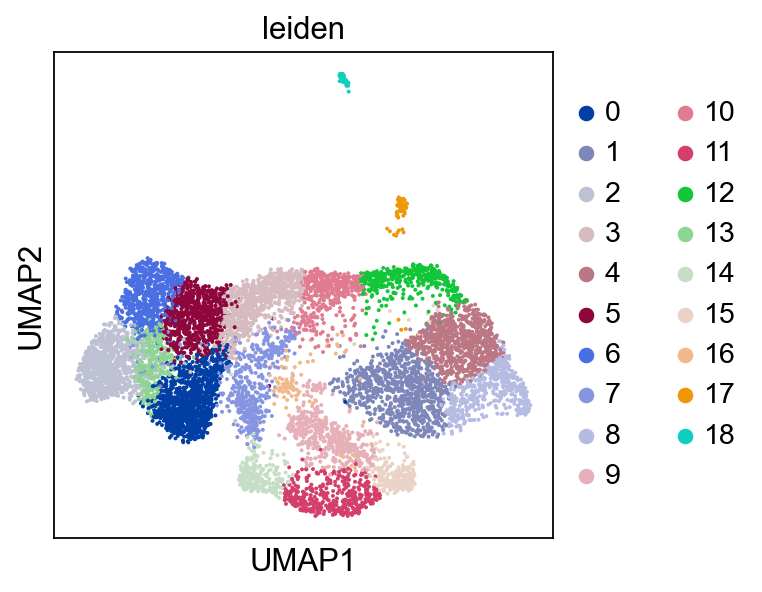

In [174]:
sc.pl.umap(adata, color=['leiden'], use_raw=False, wspace=0.3, ncols=2)

c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


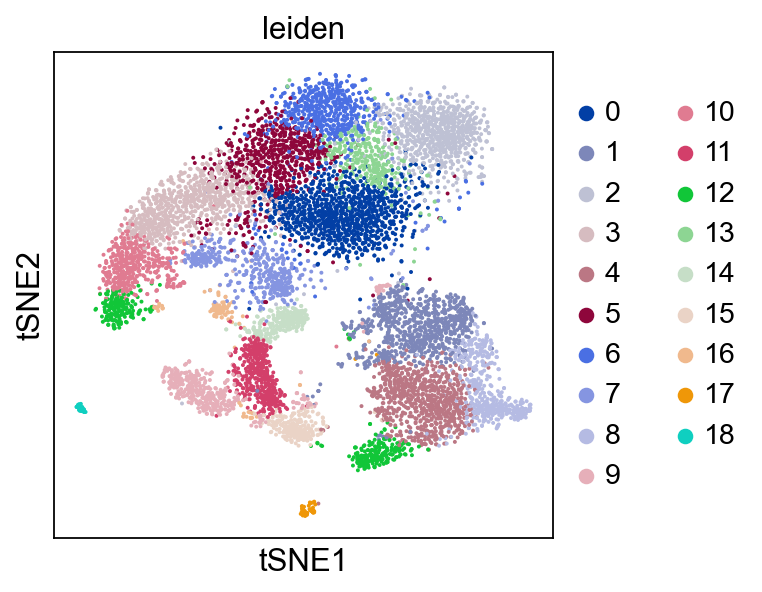

In [175]:
sc.pl.tsne(adata, use_raw=False, color='leiden', wspace=0.3, ncols=2) # color by louvain and leiden

## 7. Identifying marker genes and cell types
Before proceeding with marker gene analysis and cell type annotation, restore the raw version of the data, add the necessary annotations, and normalize the counts:

In [176]:
adata_raw_norm = adata_raw.copy()

# normalize the counts
sc.pp.normalize_total(adata_raw_norm)
# log transform the counts
sc.pp.log1p(adata_raw_norm)
# transfer over the metadata
adata_raw_norm.obsm["X_umap"] = adata.obsm["X_umap"]
adata_raw_norm.obs["leiden"] = [i for i in adata.obs["leiden"]]

normalizing counts per cell
    finished (0:00:00)


In [177]:
sc.tl.rank_genes_groups(adata_raw_norm, 'leiden', use_raw=False, method="t-test")

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:15)


In [243]:
marker_genes = pd.DataFrame(adata_raw_norm.uns["rank_genes_groups"]["names"])
marker_genes.iloc[:100].to_csv("most_variable.csv")

In [231]:
sc.get.rank_genes_groups_df(adata_raw_norm, n_genes=100)


TypeError: rank_genes_groups_df() got an unexpected keyword argument 'n_genes'

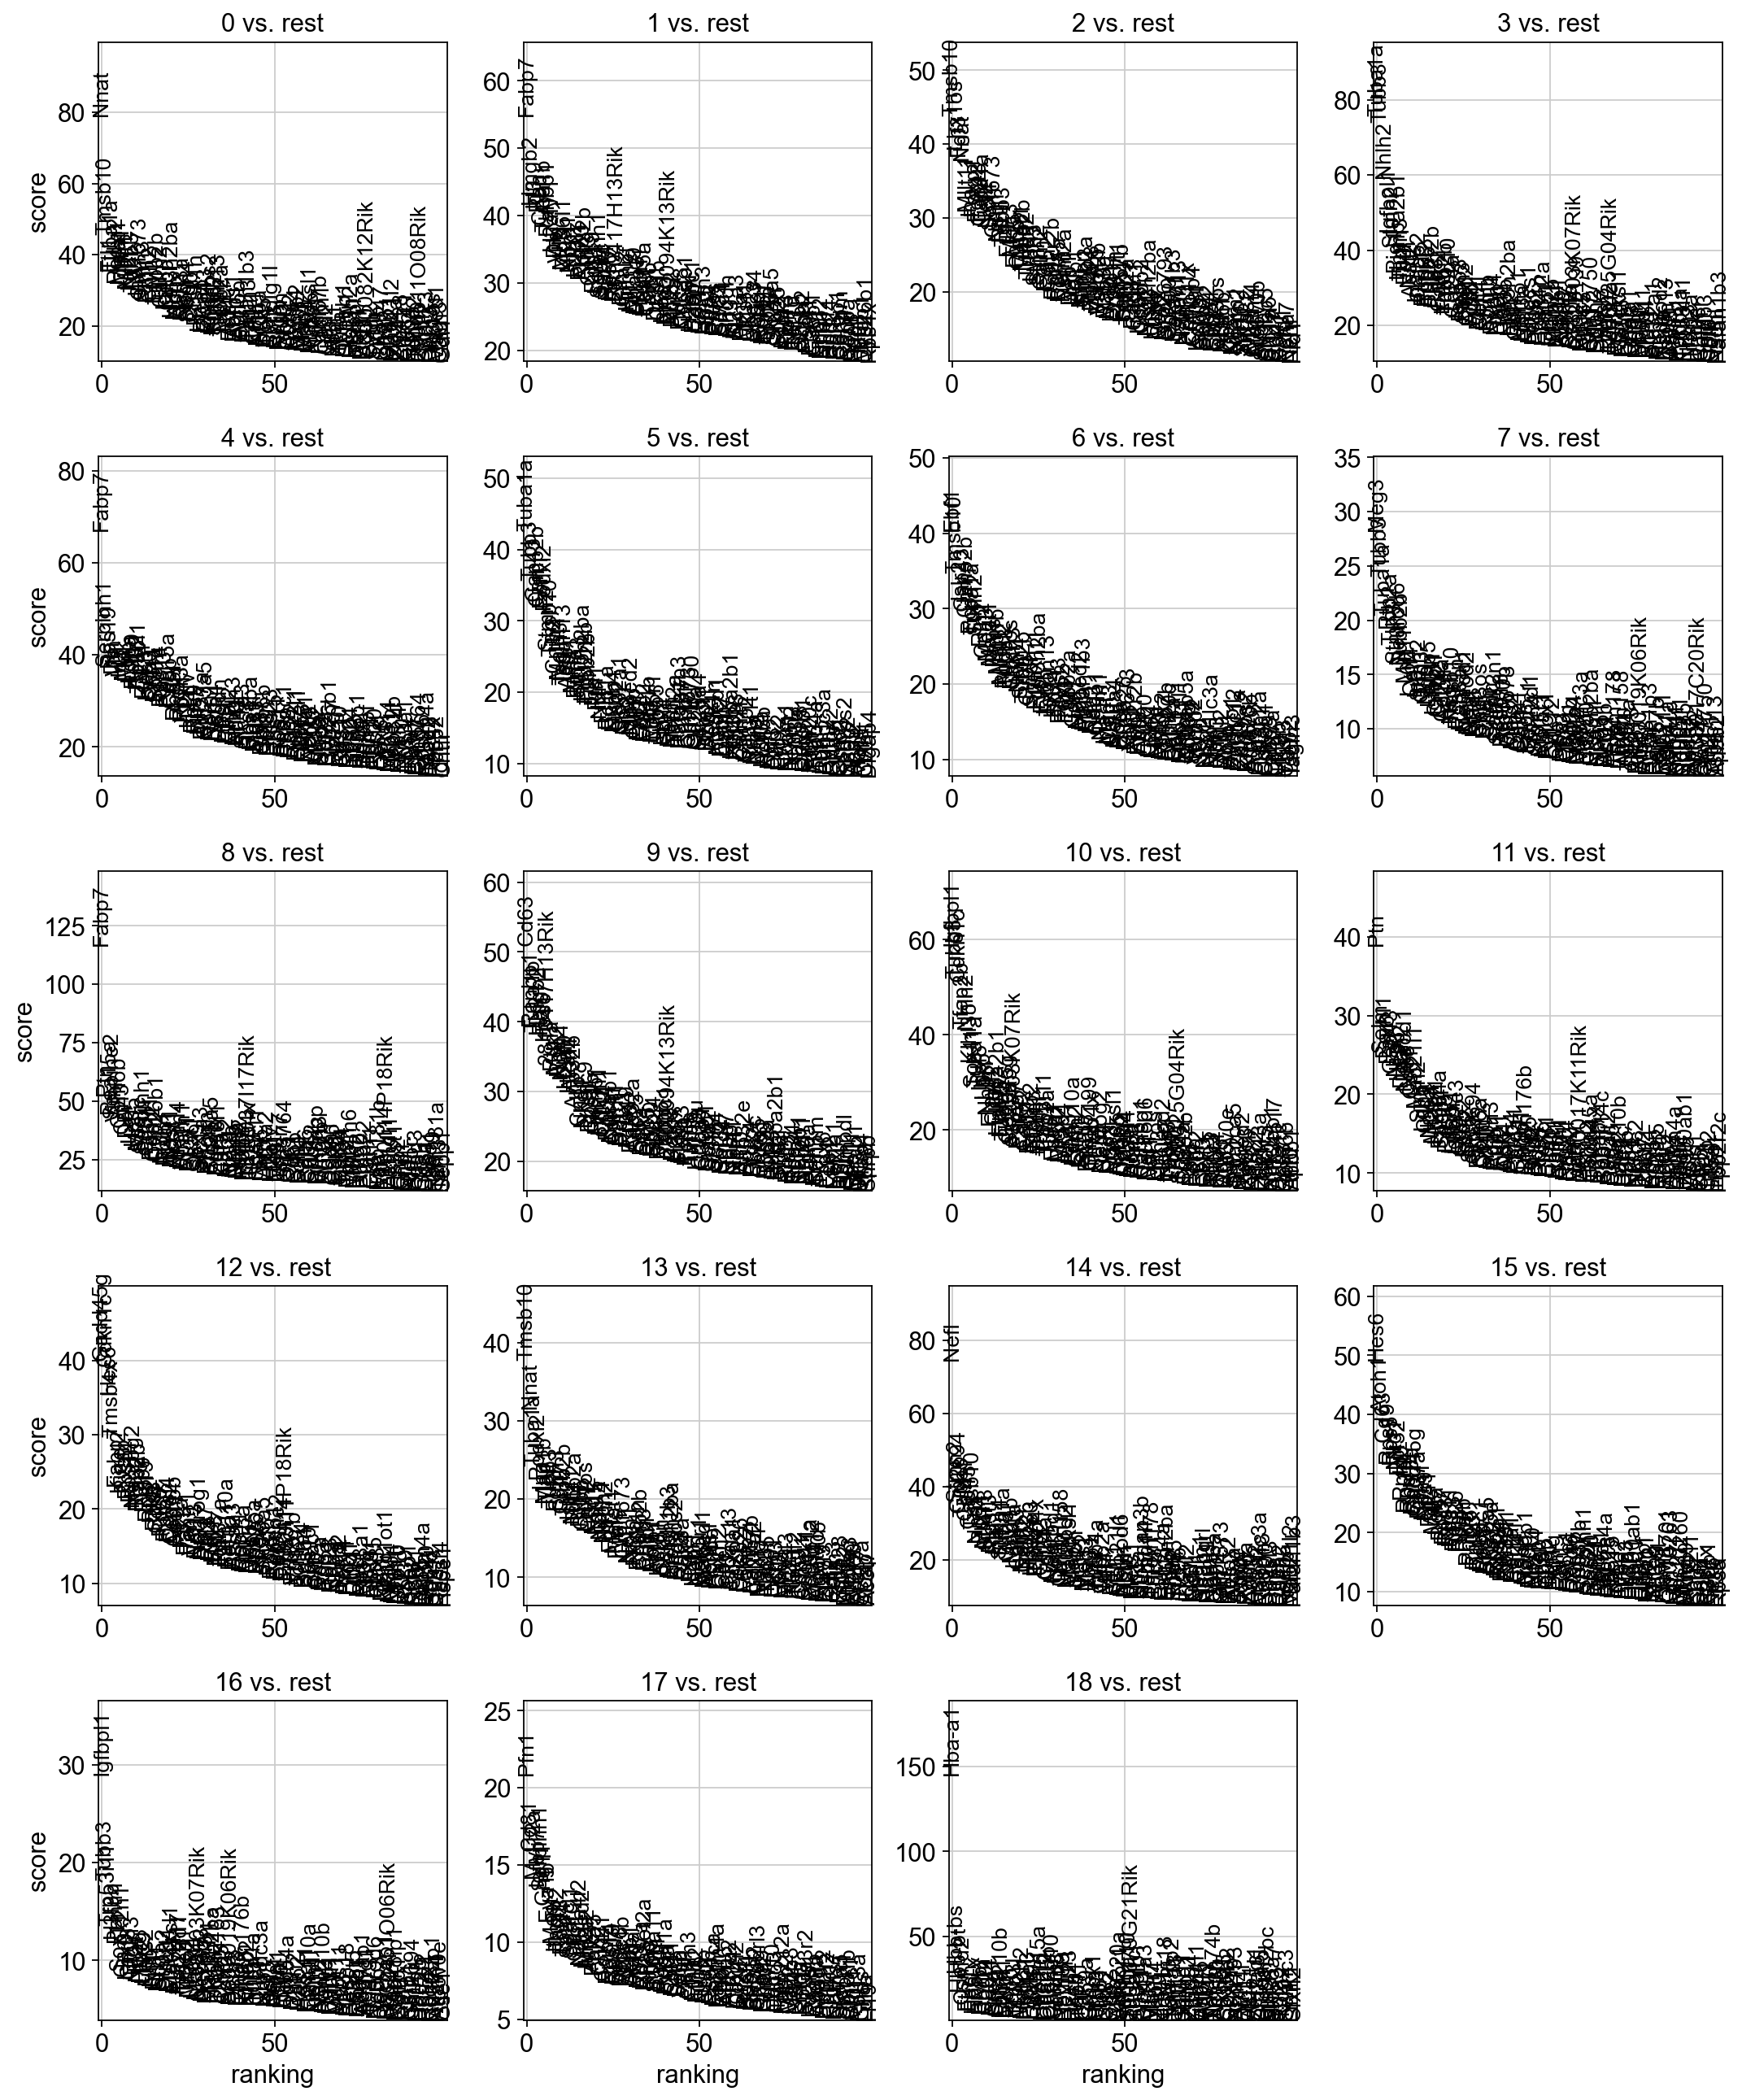

In [200]:
sc.pl.rank_genes_groups(adata_raw_norm, n_genes=100, sharey=False, fontsize=12)


AAACATACAACGGG     0
AAACATACACGGAG     1
AAACATACCGGAGA     3
AAACATACCTCATT    15
AAACATACGGACAG     6
                  ..
TTTGACTGCTTGAG     8
TTTGACTGGATAAG    10
TTTGACTGTTCCGC    14
TTTGCATGCACACA     0
TTTGCATGTCAGAC     9
Name: leiden, Length: 9458, dtype: category
Categories (19, object): ['0', '1', '2', '3', ..., '15', '16', '17', '18']

In [158]:
cell_type_markers = {
    "Progenitors": (["Hex5", "Hes1"], [0.5, 0.5, 0.5, 0.5]),
    "Gabaergic": (["Lhx5", "Lhx1"], [0.5, 0.5]),
    "Glutamergic": (["Atoh1", "Lhx9", "Barhl1"], [0.5, 0.5, 0.5])
}


## 8. Astrocytes trajectory inference method 1

In [233]:
gene_threshold = 0.60 # to change
gene_marker = "Slc1a3"
#astrocytes = adata[adata.obs_vector(gene_marker) > gene_threshold, :]

gene2_threshold = 0.60
gene_2_marker = "Sparcl1"
astrocytes = adata[
    (adata.obs_vector(gene_marker) > gene_threshold) & 
    (adata.obs_vector(gene_2_marker) > gene2_threshold)
    , :]

In [226]:
# select gene markers
cell_type = "Gabaergic"
selection = np.ones(len(adata), dtype=bool)
for gene, threshold in zip(cell_type_markers[cell_type][0], cell_type_markers[cell_type][1]):
    selection = np.logical_and(selection, adata.obs_vector(gene) > threshold)
selected_cells = adata[selection]

In [234]:
selected_cells = astrocytes

In [235]:
sc.pp.neighbors(selected_cells, n_neighbors=20, use_rep='X', method='gauss') # tune numbers of neighbors

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [239]:
set(selected_cells.obs["leiden"])

{'1', '10', '12', '15', '17', '4', '6', '8'}

In [228]:
sc.tl.diffmap(selected_cells)

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [ 1.          0.8527873   0.6651627   0.54562294  0.5155464   0.4827928
      0.47448236  0.46649852 -0.46476564 -0.4685385  -0.47226474 -0.47866437
     -0.49536324 -0.5481721  -0.7218745 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


In [229]:
sc.tl.dpt(selected_cells, n_branchings=1, n_dcs=10)

    adata.uns['iroot'] = root_cell_index
    adata.var['xroot'] = adata[root_cell_name, :].X
computing Diffusion Pseudotime using n_dcs=10
    finished: added

    'dpt_groups', the branching subgroups of dpt (adata.obs)
    'dpt_order', cell order (adata.obs) (0:00:00)


c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\jurri\miniconda3\Lib\site-packages

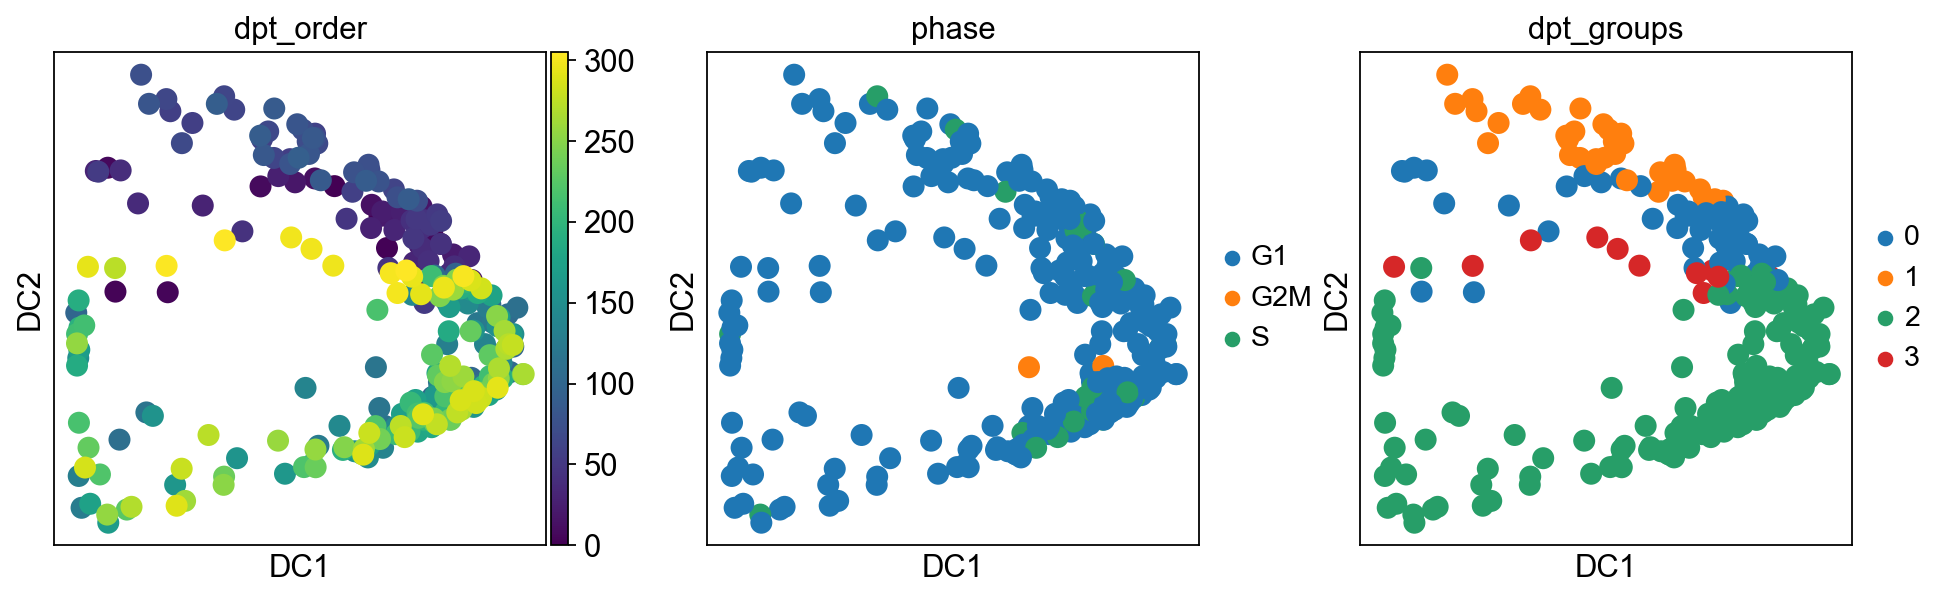

In [230]:
sc.pl.diffmap(selected_cells, color=['dpt_order', 'phase', 'dpt_groups'])

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.96516585 0.9533408  0.93292207 0.919589   0.90922403
     0.8911426  0.88814217 0.8715356  0.86110914 0.8435301  0.8322137
     0.8171911  0.7789197  0.77078825]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
    adata.uns['iroot'] = root_cell_index
    adata.var['xroot'] = adata[root_cell_name, :].X
computing Diffusion Pseudotime using n_dcs=10
    finished: added

    'dpt_groups', the branching subgroups of dpt (adata.obs)
    'dpt_order', cell order (adata.obs) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)

KeyError: 'dpt_order'

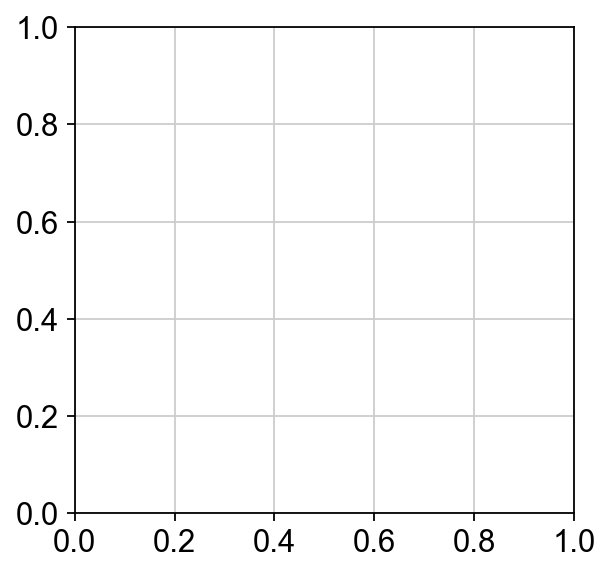

In [245]:
sc.tl.diffmap(astrocytes)
sc.pp.neighbors(astrocytes, use_rep="X_diffmap")
sc.tl.dpt(astrocytes, n_branchings=1, n_dcs=10)


computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


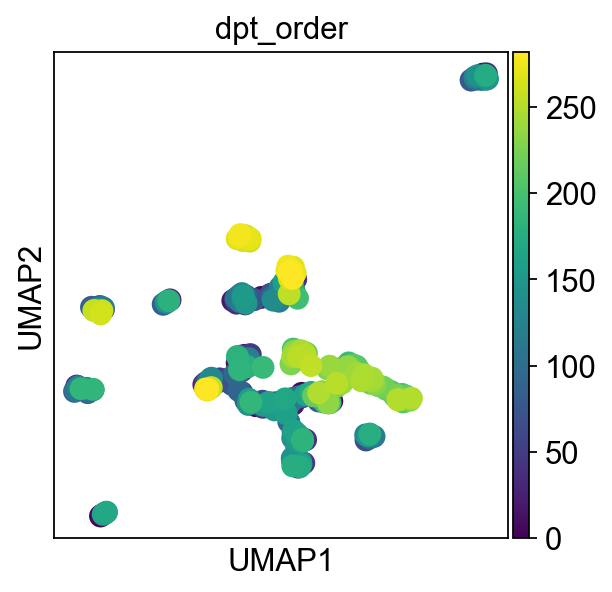

In [246]:
sc.tl.umap(astrocytes)

sc.pl.umap(astrocytes, color="dpt_order")


## 8. Astrocytes trajectory inference method 2

In [ ]:
gene_threshold = 0.80
gene_marker = "SLC1A3"
astrocytes = adata[adata.obs_vector(gene_marker) > slc1a3_threshold, :]

In [ ]:
sc.pp.recipe_zheng17(astrocytes)

In [ ]:
sc.tl.pca(astrocytes, svd_solver='arpack')

In [ ]:
sc.pp.neighbors(astrocytes, n_neighbors=4, n_pcs=20)
sc.tl.draw_graph(astrocytes)

In [ ]:
c.pl.draw_graph(astrocytes, color='paul15_clusters', legend_loc='on data')

## 8. Astrocytes trajectory inference method 3

In [ ]:
gene_threshold = 0.80
gene_marker = "SLC1A3"
astrocytes = adata[adata.obs_vector(gene_marker) > slc1a3_threshold, :]

In [ ]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)

In [ ]:
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

In [ ]:
sc.pp.neighbors(astrocytes, n_neighbors=5, method='gauss', knn=False)

In [ ]:
sc.tl.diffmap(astrocytes)

In [ ]:
sc.tl.dpt(astrocytes, n_branchings=1, n_dcs=10)

In [ ]:
sc.pl.diffmap(astrocytes, color=['dpt_pseudotime', 'dpt_groups', 'exp_groups'])